# Exercises - Detect Through Clustering

Clustering - DBSCAN
- Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from env import get_connection


In [2]:
from env import host, username, password

def get_db_url(database, host=host, user=username, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Cluster on all or a selected subset of features
frozen_detergent_deli = df[["Frozen", "Detergents_Paper", "Delicassen"]]
frozen_detergent_deli.head(2)


,Frozen,Detergents_Paper,Delicassen
customer_id,,,
0,214,2674,1338
1,1762,3293,1776


In [5]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_detergent_deli)

# Use the scaler
frozen_detergent_deli = scaler.transform(frozen_detergent_deli)
frozen_detergent_deli

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605232, 0.16355861],
       ...,
       [0.00677142, 0.36346267, 0.03888194],
       [0.01664914, 0.00404174, 0.04426366],
       [0.00065742, 0.01161082, 0.00102211]])

In [6]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(frozen_detergent_deli)


DBSCAN(eps=0.1, min_samples=20)

In [7]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Frozen", "Detergents_Paper", "Delicassen"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_detergent_deli, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093


In [8]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()


 0    423
-1     17
Name: labels, dtype: int64

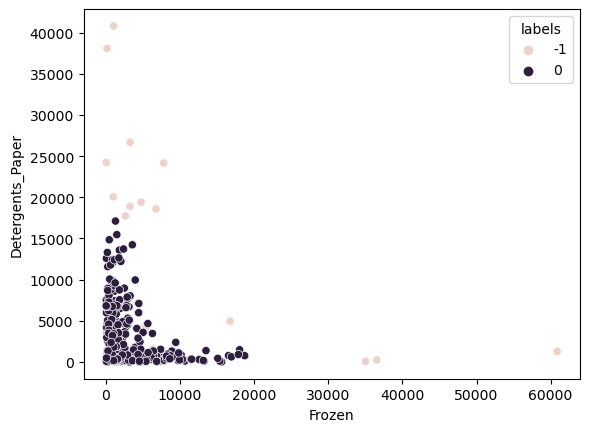

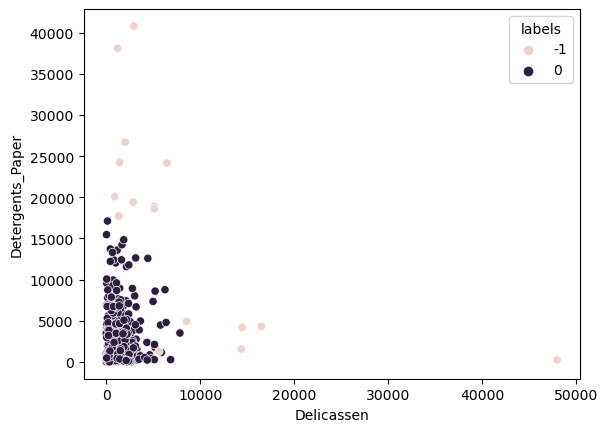

In [9]:
sns.scatterplot(x=df.Frozen, y=df.Detergents_Paper, hue=df.labels)
plt.show()

sns.scatterplot(x=df.Delicassen, y=df.Detergents_Paper, hue=df.labels)
plt.show()


Text(0.5, 0, 'Deli')

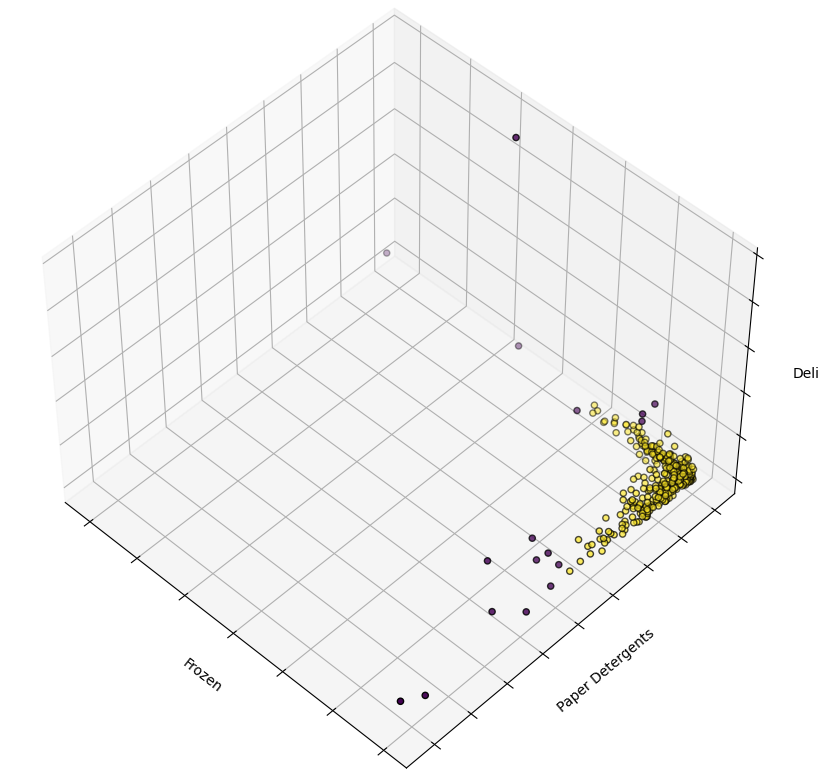

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Frozen, df.Detergents_Paper, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Paper Detergents')
ax.set_zlabel('Deli')


- Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [11]:
#Define query
query = '''
        SELECT *
        FROM logs
        '''

In [12]:
#Define url
url = get_connection('curriculum_logs')

In [13]:
curr_df = pd.read_sql(query, url, index_col="date")

In [14]:
curr_df['cohort_id'].isnull().values.any()

True

In [15]:
curr_df

,time,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33


In [20]:
mask = curr_df['cohort_id'].isnull()
nan_df = pd.DataFrame(curr_df[mask])
nan_df

,time,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,16:46:16,/,48,NaN,97.105.19.61
2018-01-26,16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61
2018-01-26,17:54:24,/,48,NaN,97.105.19.61
2018-01-26,18:32:03,/,48,NaN,97.105.19.61
2018-01-26,18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61
...,...,...,...,...,...
2021-04-21,12:49:00,javascript-ii,717,NaN,136.50.102.126
2021-04-21,12:49:02,javascript-ii/es6,717,NaN,136.50.102.126
2021-04-21,12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126


In [51]:
curr_df['user_id'].describe()

count    900223.000000
mean        458.825707
std         249.296767
min           1.000000
25%         269.000000
50%         475.000000
75%         660.000000
max         981.000000
Name: user_id, dtype: float64

In [48]:
array_cohort = curr_df['cohort_id'].unique()
array_cohort

array([  8.,  22.,  21.,   1.,  16.,  18.,  19.,  nan,  13.,  14.,  15.,
         7.,   4.,  12.,  17.,  23.,   2.,   9.,  11.,  24.,  25.,  26.,
         6.,  27.,  28.,  29.,  31.,  32.,  33.,  34.,  51.,  52.,  53.,
        55.,  56.,  57.,   5.,  58.,  59.,  61.,  62., 132., 134., 133.,
       135., 138., 137., 139.])

In [50]:
array_cohort.sort()
array_cohort

array([  1.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  21.,  22.,  23.,  24.,  25.,
        26.,  27.,  28.,  29.,  31.,  32.,  33.,  34.,  51.,  52.,  53.,
        55.,  56.,  57.,  58.,  59.,  61.,  62., 132., 133., 134., 135.,
       137., 138., 139.,  nan])

In [18]:
curr_path_df = curr_df.loc[curr_df['cohort_id'] == 'NaN']
curr_path_df


,time,path,user_id,cohort_id,ip
date,,,,,


In [ ]:
curr_df

In [ ]:
# Cluster on all or a selected subset of features
user_cohort = curr_df[["user_id", "cohort_id"]]
user_cohort.head(2)

In [ ]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(user_cohort)

# Use the scaler
user_cohort = scaler.transform(user_cohort)
user_cohort

In [ ]:
user_cohort.isnull().sum()

In [ ]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(user_cohort)

- Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [54]:
# reads in the red wine data set and assigns the df to a variable
red_wine_df = pd.read_csv('https://query.data.world/s/bqmesefq3qbzhzjyyjd52u7lfntuzv')
    
# creates a column named red_or_white and assigns red wine to 1 for yes
red_wine_df.insert(0, 'red_or_white', 1)

# reads in the white wine data set and assigns the df to a variable
white_wine_df = pd.read_csv('https://query.data.world/s/hqayd6nqceg6wkq3ziib6ostwmw4pz')

# creates a column named red_or_white and assigns white wine to 0 for no
white_wine_df.insert(0, 'red_or_white', 0)

# appends the red and white wine dataframes to one dataframe that includes the new
# column red_or_white
wine_df = red_wine_df.append(white_wine_df, ignore_index=True)
    
# returns the appended wine dataframe
wine_df

,red_or_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,0,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,0,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,0,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [55]:
# Cluster on all or a selected subset of features
ph_sulphates_alcohol = wine_df[["pH", "sulphates", "alcohol"]]
ph_sulphates_alcohol.head(2)


,pH,sulphates,alcohol
0,3.51,0.56,9.4
1,3.20,0.68,9.8


In [56]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(ph_sulphates_alcohol)

# Use the scaler
ph_sulphates_alcohol = scaler.transform(ph_sulphates_alcohol)
ph_sulphates_alcohol


array([[0.6124031 , 0.19101124, 0.20289855],
       [0.37209302, 0.25842697, 0.26086957],
       [0.41860465, 0.24157303, 0.26086957],
       ...,
       [0.20930233, 0.13483146, 0.20289855],
       [0.48062016, 0.08988764, 0.69565217],
       [0.41860465, 0.05617978, 0.55072464]])

In [57]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(ph_sulphates_alcohol)


DBSCAN(eps=0.1, min_samples=20)

In [ ]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["pH", "sulphates", "alcohol"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = wine_df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(ph_sulphates_alcohol, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()
